# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: L1 regularization in practice
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202201

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 
from torch.utils.data import DataLoader

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris', data_home='../seaborn-data-master')

In [3]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Specify the model architecture and training plan

In [5]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005)

  return ANNiris,lossfun,optimizer

In [6]:
# explore the model in more detail
tmpmodel = createANewModel()[0]

# print the model architecture
print(tmpmodel)

# print the model's parameters
for i in tmpmodel.named_parameters():
  print(i[0],i[1].shape,i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


# Function that trains the model

In [8]:
# train the model

# global parameter
numepochs = 1000

def trainTheModel(L1lambda):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # count the total number of weights in the model
  nweights = 0
  for pname,weight in ANNiris.named_parameters():
    if 'bias' not in pname:
      nweights = nweights + weight.numel()


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)



      ### add L1 term
      L1_term = torch.tensor(0.,requires_grad=True)

      # sum up all abs(weights)
      for pname,weight in ANNiris.named_parameters():
        if 'bias' not in pname:
           L1_term = L1_term + torch.sum(torch.abs(weight))
      
      # add to loss term
      loss = loss + L1lambda*L1_term/nweights
      


      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses


# Bring it to life!

In [9]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
L1lambda = .001
trainAcc,testAcc,losses = trainTheModel(L1lambda)

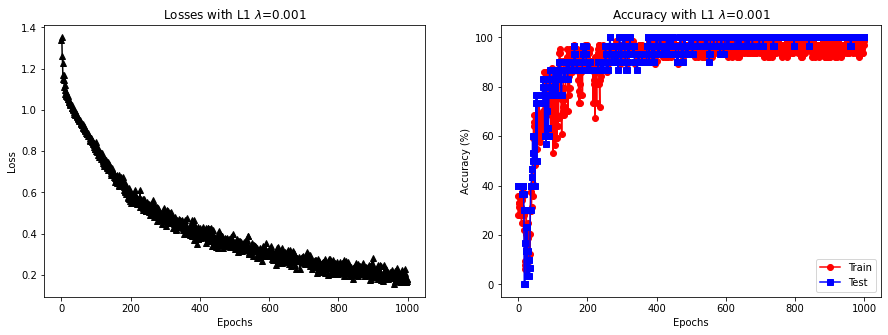

In [10]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [11]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

# Now for the parameteric experiment

In [12]:
# range of L1 regularization amounts
L1lambda = np.linspace(0,.005,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(L1lambda)))
accuracyResultsTest  = np.zeros((numepochs,len(L1lambda)))


# loop over batch sizes
for li in range(len(L1lambda)):

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel()
  trainAcc,testAcc,losses = trainTheModel(L1lambda[li])

  # store data
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)

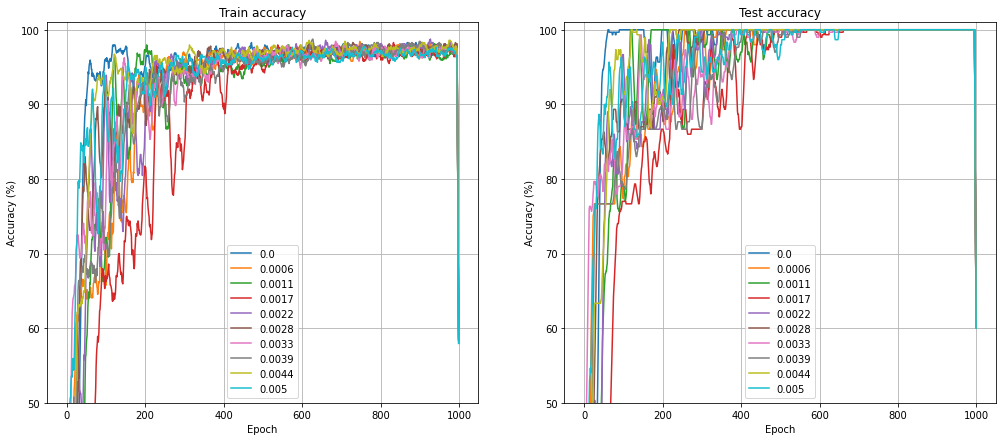

In [13]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,4) for i in L1lambda]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

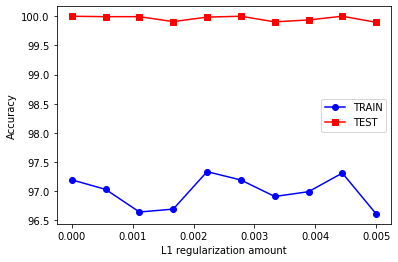

In [14]:
# show average accuracy by L1 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Additional explorations

In [ ]:
# 1) In the previous video we used a pytorch function to implement L2 regularization, and in this video we implemented 
#    L1 regularization manually. Modify the code here to create a manual L2 regularizer.
# 
# 2) Based on your modification above, create a combined L1+L2 regularizer. Does it make sense to use the same lambda
#    parameter, or do you think it should be adjusted?
# 